In [ ]:
import time
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import SQ_LASSO

dtype = torch.float
device_id = "cuda"

In [3]:
def generate_data(N, M, D, dtype=torch.float, device="cuda"):
    # sample D-dimensional array of random points in [0,1]^D
    samples = torch.rand(N, D, dtype=dtype, device=device, requires_grad=False)

    # define D-dimensional array of frequencies in [-M, M]^D based on hyperbolic cross density
    def hyp_cross(d, M):
        if d == 1:
            return [[k] for k in range(-M, M + 1)]
        out = []
        for k in range(-M, M + 1):
            for temp in hyp_cross(d - 1, int(M / max(1, abs(k)))):
                out.append([k] + temp)
        return out

    # frequencies in [-M, M]^D scaled by -2π
    frequencies = (
        -2
        * math.pi
        * torch.round(
            torch.FloatTensor(hyp_cross(D, M)).to(dtype=torch.double, device=device_id)
        )
    )
    frequencies.requires_grad = False
    M_f = frequencies.size(0)

    # function in H^3/2 with known Fourier coefficients
    def fun1(x, D):
        out = torch.ones_like(x[:, 0], requires_grad=False)
        for i in range(D):
            out = out * torch.clip(
                0.2 - (x[:, i] - 0.5) ** 2,
                min=0,
                max=None,
            )
        return (15 / (4 * np.sqrt(3)) * 5 ** (3 / 4)) ** D * out[:, None]

    def fun1_fourier_coeffs(f, D):
        out = torch.ones_like(f[:, 0], requires_grad=False)
        for i in range(D):
            tmp = (
                5 ** (5 / 4)
                * np.sqrt(3)
                * (-1) ** torch.round(f[:, i] / (2 * np.pi))
                * (
                    np.sqrt(5) * torch.sin(f[:, i] / np.sqrt(5))
                    - f[:, i] * torch.cos(f[:, i] / np.sqrt(5))
                )
                / (f[:, i] ** 3)
            )
            tmp[torch.isnan(tmp)] = 5 ** (1 / 4) / np.sqrt(3)
            out = out * tmp
        return out

    # compute truncation error
    coeffs_gt_d = torch.zeros((M_f, 2), dtype=torch.double)
    coeffs_gt_d[:, 0] = fun1_fourier_coeffs(frequencies.to(dtype=torch.double), D)
    trunc_error = torch.sqrt(1 - torch.sum(coeffs_gt_d[:, 0] ** 2))

    # cast to chosen dtype/device
    frequencies = frequencies.to(dtype=dtype)
    coeffs_gt = torch.zeros((M_f, 2), dtype=dtype, device=device_id)
    coeffs_gt[:, 0] = fun1_fourier_coeffs(frequencies, D)

    # since we approximate real functions, we can drop half of the Fourier coeffcients
    frequencies_half = frequencies[: math.ceil(frequencies.size(0) / 2), :]

    # create vector with normalized function values
    values = fun1(samples, D)

    # Optionally print info
    print("Number of Fourier frequencies in Hyperbolic cross:", M_f)
    print("Truncation error computed with double precision:", trunc_error.item())

    return frequencies, frequencies_half, samples, values, coeffs_gt, trunc_error

Number of Fourier frequencies in Hyperbolic cross: 31743
Truncation error computed with double precision: 0.009102077974971534
Estimated norm of A is 1.3601933717727661
Starting PDHGM call 1  out of 10


  0%|          | 0/9 [00:00<?, ?it/s]

Starting PDHGM call 2  out of 10


  0%|          | 0/15 [00:00<?, ?it/s]

Starting PDHGM call 3  out of 10


  0%|          | 0/25 [00:00<?, ?it/s]

Starting PDHGM call 4  out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

Starting PDHGM call 5  out of 10


  0%|          | 0/66 [00:00<?, ?it/s]

Starting PDHGM call 6  out of 10


  0%|          | 0/109 [00:00<?, ?it/s]

Starting PDHGM call 7  out of 10


  0%|          | 0/179 [00:00<?, ?it/s]

Starting PDHGM call 8  out of 10


  0%|          | 0/295 [00:00<?, ?it/s]

Starting PDHGM call 9  out of 10


  0%|          | 0/486 [00:00<?, ?it/s]

Starting PDHGM call 10  out of 10


  0%|          | 0/801 [00:00<?, ?it/s]

Time to compute rLASSO solution is 1.5359911918640137 seconds
Final residual of rLASSO solution is 0.009694659151136875
Relative reconstruction error of rLASSO solution: 0.01777693052500129
Number of nonzero entries of rLASSO solution (with tolerance 1e-4): 8273
Residual of least squares solution is 0.005449400749057531
Relative reconstruction error of least squares solution is 0.021363390429910423


Text(0.5, 1.0, 'Difference to Ground Truth Fourier Coefficients')

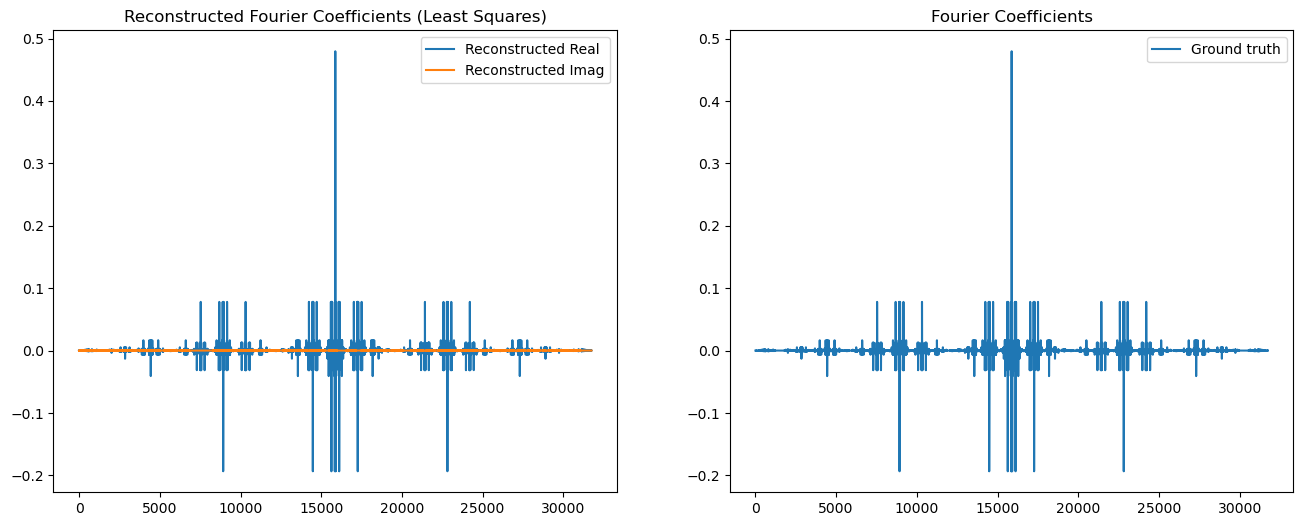

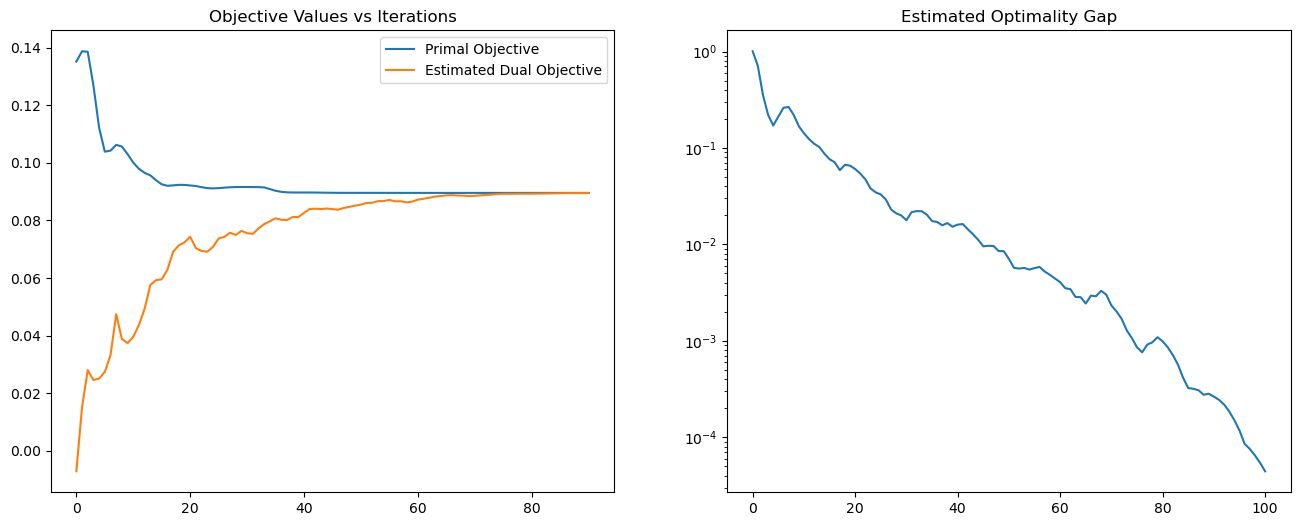

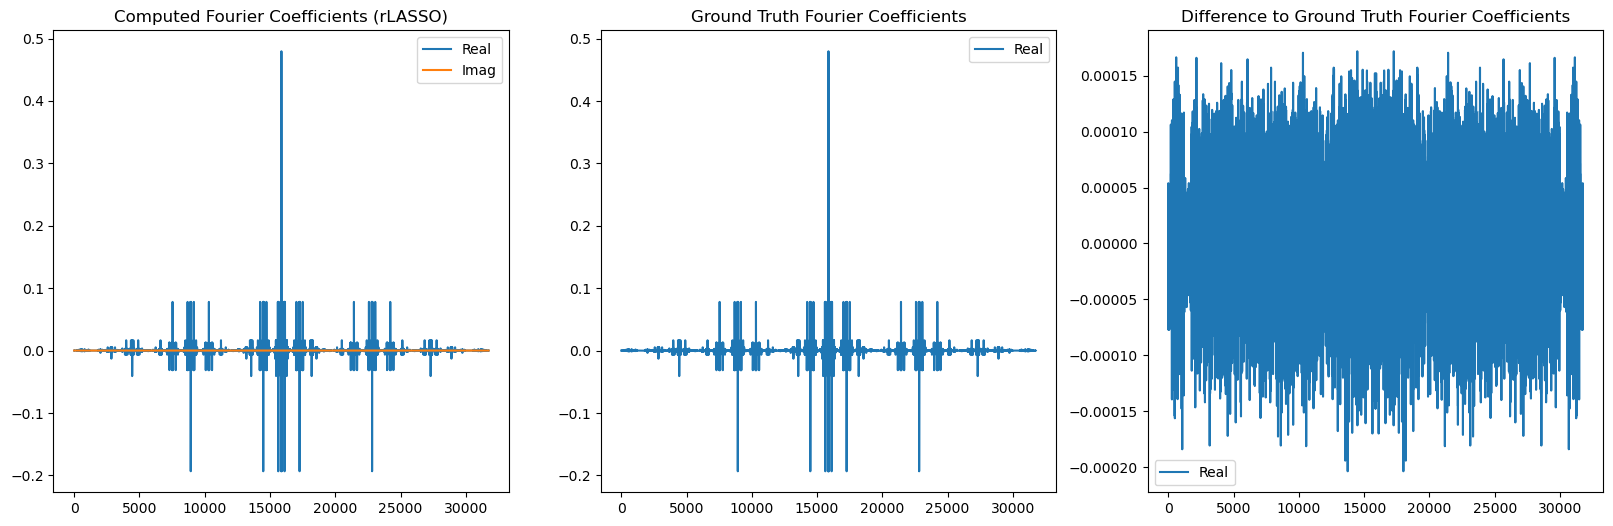

In [18]:
# run prim dual algorithm with restarts
# Here we set the parameters, tested M are 5,8,20,30,60,135
frequencies, frequencies_half, samples, values, coeffs_gt, trunc_error = generate_data(
    50_000, 15, 5, device=device_id, dtype=dtype
)

start = time.time()
coeffs_rec, vals, vals_dual, coeffs_lsr_rec, residuals = (
    SQ_LASSO.Reconstruction_Fourier(
        samples, values, frequencies_half, lstsq_rec=True, restarts=10, tol=3e-6
    )
)

# add missing Fourier coeffcients
coeffs_rec = torch.cat(
    (
        coeffs_rec[:-1, :] / 2,
        coeffs_rec[-1, :][None],
        torch.flipud(coeffs_rec[:-1, :]) / 2,
    ),
    0,
)
coeffs_rec[-math.ceil(frequencies.size(0) / 2) :, 1] = -coeffs_rec[
    -math.ceil(frequencies.size(0) / 2) :, 1
]

coeffs_lsr_rec = torch.cat(
    (
        coeffs_lsr_rec[:-1, :] / 2,
        coeffs_lsr_rec[-1, :][None],
        torch.flipud(coeffs_lsr_rec[:-1, :]) / 2,
    ),
    0,
)
coeffs_lsr_rec[-math.ceil(frequencies.size(0) / 2) :, 1] = -coeffs_lsr_rec[
    -math.ceil(frequencies.size(0) / 2) :, 1
]

# some evaluation metrics (rLASSO)
print("Time to compute rLASSO solution is", time.time() - start, "seconds")
print("Final residual of rLASSO solution is", residuals[0].item())
print(
    "Relative reconstruction error of rLASSO solution:",
    (trunc_error + torch.linalg.norm(coeffs_gt - coeffs_rec)).item(),
)
print(
    "Number of nonzero entries of rLASSO solution (with tolerance 1e-4):",
    torch.sum(torch.abs(coeffs_rec) > 1e-4).item(),
)

# evaluation of some metrics (Least Squares)
print("Residual of least squares solution is", residuals[1].item())
print(
    "Relative reconstruction error of least squares solution is",
    (trunc_error + torch.linalg.norm(coeffs_gt - coeffs_lsr_rec)).item(),
)

fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(coeffs_lsr_rec[:, 0].cpu(), label="Reconstructed Real")
plt.plot(coeffs_lsr_rec[:, 1].cpu(), label="Reconstructed Imag")
plt.legend()
plt.title("Reconstructed Fourier Coefficients (Least Squares)")

plt.subplot(1, 2, 2)
plt.plot(coeffs_gt[:, 0].cpu(), label="Ground truth")
plt.legend()
plt.title("Fourier Coefficients")

fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(torch.tensor(vals[10:], device="cpu"), label="Primal Objective")
plt.plot(
    torch.tensor(vals_dual[10:], device="cpu"),
    label="Estimated Dual Objective",
)
plt.legend()
plt.title("Objective Values vs Iterations")

plt.subplot(1, 2, 2)
plt.plot(torch.tensor(vals, device="cpu") - torch.tensor(vals_dual, device="cpu"))
plt.yscale("log")
plt.title("Estimated Optimality Gap")

fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.plot(coeffs_rec[:, 0].cpu(), label="Real")
plt.plot(coeffs_rec[:, 1].cpu(), label="Imag")
plt.legend()
plt.title("Computed Fourier Coefficients (rLASSO)")

plt.subplot(1, 3, 2)
plt.plot(coeffs_gt[:, 0].cpu(), label="Real")
plt.legend()
plt.title("Ground Truth Fourier Coefficients")

plt.subplot(1, 3, 3)
plt.plot(coeffs_rec[:, 0].cpu() - coeffs_gt[:, 0].cpu(), label="Real")
plt.legend()
plt.title("Difference to Ground Truth Fourier Coefficients")